### Aleksandra Jonas, Aleksandra Gronowska, Iwona Christop
# Zadanie 9-10, zadanie 1 - VGG16 + ResNet on train_test_sw 

### Przygotowanie danych

In [40]:
from IPython.display import Image, display

In [41]:
import sys
import subprocess
import pkg_resources
import numpy as np

required = { 'scikit-image'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
# VGG16 requires images to be of dim = (224, 224, 3)
newSize = (224,224)

if missing: 
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

def load_train_data(input_dir):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib
    
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = img[:, :, :3]
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255 #normalizacja
                train_img.append(img)
        categories_count.append(count)
    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

def load_test_data(input_dir):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib

    image_path = Path(input_dir)

    labels_path = image_path.parents[0] / 'test_labels.json'

    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)
    
    test_img = []

    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)#zwraca ndarry postaci xSize x ySize x colorDepth
        img = img[:, :, :3]
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
        img = img / 255#normalizacja
        test_img.append(img)
        labels.append(e['value'])

    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [42]:
def create_tf_ds(X_train, y_train_enc, X_validate, y_validate_enc, X_test, y_test_enc):
    import tensorflow as tf
    
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
    validation_ds = tf.data.Dataset.from_tensor_slices((X_validate, y_validate_enc))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))

    train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
    test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
    validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

    print("Training data size:", train_ds_size)
    print("Test data size:", test_ds_size)
    print("Validation data size:", validation_ds_size)

    train_ds = (train_ds
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
    test_ds = (test_ds
                    .shuffle(buffer_size=train_ds_size)
                    .batch(batch_size=32, drop_remainder=True))
    validation_ds = (validation_ds
                    .shuffle(buffer_size=train_ds_size)
                    .batch(batch_size=32, drop_remainder=True))
    
    return train_ds, test_ds, validation_ds

In [43]:
def get_run_logdir(root_logdir):
    import os
    import time

    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [44]:
def diagram_setup(model_name):
    from tensorflow import keras
    import os
    
    root_logdir = os.path.join(os.curdir, f"logs\\fit\\{model_name}\\")
    
    run_logdir = get_run_logdir(root_logdir)
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [45]:
# Data load
data_train = load_train_data("./train_test_sw/train_sw")
values_train = data_train['values']
labels_train = data_train['labels']

data_test = load_test_data("./train_test_sw/test_sw")
X_test = data_test['values']
y_test = data_test['labels']

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(values_train, labels_train, test_size=0.2, random_state=42)

In [47]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y_train_enc = class_le.fit_transform(y_train)
y_validate_enc = class_le.fit_transform(y_validate)
y_test_enc = class_le.fit_transform(y_test)

In [48]:
train_ds, test_ds, validation_ds = create_tf_ds(X_train, y_train_enc, X_validate, y_validate_enc, X_test, y_test_enc)

Training data size: 821
Test data size: 259
Validation data size: 206


## VGG16

In [49]:
diagram_setup('vgg_sw')

In [50]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.applications import VGG16
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# model = keras.models.Sequential([
#     keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(224,224,3), padding="same"),
#     keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(224,224,3), padding="same"),
#     keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#     keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#     keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#     keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#     keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#     keras.layers.Flatten(),
#     keras.layers.Dense(units = 4096, activation='relu'),
#     keras.layers.Dense(units = 4096, activation='relu'),
#     keras.layers.Dense(units = 5, activation='softmax')
# ])

# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of resnet
vgg2 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg2.layers:
  layer.trainable = False
  
  # useful for getting number of classes
classes = 5
  

# our layers - you can add more if you want
x = Flatten()(vgg2.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(5, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg2.input, outputs=prediction)

# view the structure of the model
model.summary()
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

#train_ds_vgg_sw, test_ds_vgg_sw, validation_ds_vgg_sw
# fit the model
vggr = model.fit_generator(
  train_ds,
  validation_data=validation_ds,
  epochs=25,
  steps_per_epoch=len(train_ds),
  validation_steps=len(validation_ds)
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

/var/folders/3r/c8tg1h051m18qhsdccdysrt40000gn/T/ipykernel_11345/3456911324.py:75: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vggr = model.fit_generator(


25/25 [==============================] - 117s 5s/step - loss: 1.4384 - accuracy: 0.4363 - val_loss: 0.8596 - val_accuracy: 0.6719
Epoch 2/25
25/25 [==============================] - 121s 5s/step - loss: 0.6040 - accuracy: 0.7975 - val_loss: 0.6615 - val_accuracy: 0.7552
Epoch 3/25
25/25 [==============================] - 126s 5s/step - loss: 0.3955 - accuracy: 0.9000 - val_loss: 0.5536 - val_accuracy: 0.7969
Epoch 4/25
25/25 [==============================] - 124s 5s/step - loss: 0.3278 - accuracy: 0.9237 - val_loss: 0.5154 - val_accuracy: 0.8438
Epoch 5/25
25/25 [==============================] - 124s 5s/step - loss: 0.2700 - accuracy: 0.9350 - val_loss: 0.5352 - val_accuracy: 0.7969
Epoch 6/25
25/25 [==============================] - 119s 5s/step - loss: 0.2109 - accuracy: 0.9538 - val_loss: 0.3983 - val_accuracy: 0.8854
Epoch 7/25
25/25 [==============================] - 117s 5s/step - loss: 0.1713 - accuracy: 0.9812 - val_loss: 0.3841 - val_accuracy: 0.8802
Epoch 8/25
25/25 [======

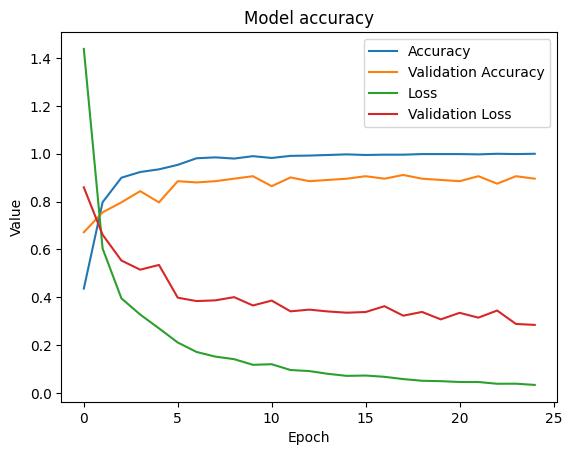

In [51]:
import matplotlib.pyplot as plt
plt.plot(vggr.history["accuracy"])
plt.plot(vggr.history['val_accuracy'])
plt.plot(vggr.history['loss'])
plt.plot(vggr.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [52]:
model.evaluate(test_ds)

8/8 [==============================] - 29s 4s/step - loss: 0.3817 - accuracy: 0.8633


[0.38167834281921387, 0.86328125]

## ResNet101V2

In [53]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from keras.applications import ResNet101V2

# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of resnet
resnet = ResNet101V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False
  
  # useful for getting number of classes
classes = 5
  

# our layers - you can add more if you want
x = Flatten()(resnet.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(5, activation='softmax')(x)

In [54]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [55]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

#train_ds_vgg_sw, test_ds_vgg_sw, validation_ds_vgg_sw
# fit the model
r = model.fit_generator(
  train_ds,
  validation_data=validation_ds,
  epochs=25,
  steps_per_epoch=len(train_ds),
  validation_steps=len(validation_ds)
)

Epoch 1/25


/var/folders/3r/c8tg1h051m18qhsdccdysrt40000gn/T/ipykernel_11345/3602206220.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


25/25 [==============================] - 59s 2s/step - loss: 3.6952 - accuracy: 0.7675 - val_loss: 1.0397 - val_accuracy: 0.9427
Epoch 2/25
25/25 [==============================] - 55s 2s/step - loss: 0.2606 - accuracy: 0.9688 - val_loss: 0.6033 - val_accuracy: 0.9479
Epoch 3/25
25/25 [==============================] - 55s 2s/step - loss: 0.0624 - accuracy: 0.9887 - val_loss: 0.7021 - val_accuracy: 0.9323
Epoch 4/25
25/25 [==============================] - 55s 2s/step - loss: 0.0150 - accuracy: 0.9987 - val_loss: 0.4405 - val_accuracy: 0.9688
Epoch 5/25
25/25 [==============================] - 56s 2s/step - loss: 0.0123 - accuracy: 0.9975 - val_loss: 0.3344 - val_accuracy: 0.9740
Epoch 6/25
25/25 [==============================] - 56s 2s/step - loss: 1.9117e-07 - accuracy: 1.0000 - val_loss: 0.1343 - val_accuracy: 0.9844
Epoch 7/25
25/25 [==============================] - 56s 2s/step - loss: 4.4405e-08 - accuracy: 1.0000 - val_loss: 0.2787 - val_accuracy: 0.9844
Epoch 8/25
25/25 [=====

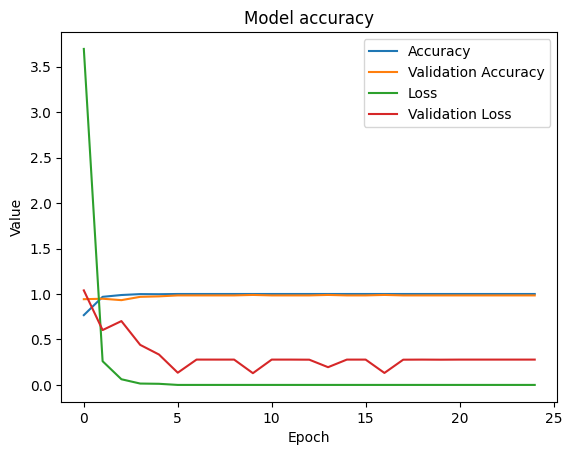

In [56]:
# loss
plt.plot(r.history["accuracy"])
plt.plot(r.history['val_accuracy'])
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

model.save('resnet_1.h5')

In [57]:
model.evaluate(test_ds)

8/8 [==============================] - 15s 2s/step - loss: 0.7370 - accuracy: 0.9414


[0.7369823455810547, 0.94140625]